In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from pprint import pprint

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud


import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aquil\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_pickle('pre-processed.pkl')

In [3]:
df.shape

(49458, 5)

In [4]:
df = df.drop(['tidy_tweet','tidy_tweet_tokens','no_stop_joined'], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49458 entries, 0 to 49457
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_text      49458 non-null  object
 1   tokens_no_stop  49458 non-null  object
dtypes: object(2)
memory usage: 772.9+ KB


In [6]:
df.head()

,tweet_text,tokens_no_stop
0,Islam is a religion full of blessings and good...,"[islam, full, blessings, good, deeds, also, re..."
1,@ wagner_claire Religion and pity are antonyms...,"[pity, antonyms, disaster, humanity, live, wit..."
2,if the only reason people are on twitter is to...,"[reason, people, argue, hitler, count]"
3,Religion is needed to provide a moral compass ...,"[needed, provide, moral, compass, lack, empathy]"
4,plus my religion has never been 'holier' than ...,"[plus, never, holier, regular, life, regular, ..."


In [7]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

In [8]:
df['tweet_text_p'] = np.vectorize(remove_links)(df['tweet_text'])

In [9]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"twitter.com\S+", "", tweet)
    return tweet_no_link

In [10]:
df['tweet_text_p'] = np.vectorize(remove_links)(df['tweet_text_p'])

In [11]:
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [12]:
df['tweet_text_p'] = np.vectorize(remove_users)(df['tweet_text_p'], "@ [\w]*", "@[\w]*")

In [13]:
# We decided to keep hashtags because they add value to the sentiment.
# Example df.tweet_text[20]
def remove_hashtags(tweet, pattern1):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [14]:
df['tweet_text_p'] = np.vectorize(remove_hashtags)(df['tweet_text_p'], "#")

In [15]:
# It adds to the neutrality of the tweet as the compound score is the sum of all words sentiment score. 
# Example df.tweet_text[43]
def remove_word(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, "", tweet)
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [16]:
df['tweet_text_p'] = np.vectorize(remove_word)(df['tweet_text_p'], "religion", "Religion")

In [17]:
# Removing Punctuation has no significant impact in most cases 
# In some cases reduces the neutrality because of words in parentheses
# Example df.tweet_text[50]
# df['pre_processed_1'] = df['pre_processed'].str.replace("[^a-zA-Z#]", " ")

In [18]:
df.drop_duplicates(subset=['tweet_text_p'], keep='first', inplace=True)

In [19]:
df = df[~df.tweet_text_p.str.contains("Retweeted")]

In [20]:
df.shape

(48617, 3)

In [21]:
# Create an object of Vader Sentiment Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

In [22]:
negative = []
neutral = []
positive = []
compound = []

In [23]:
def sentiment_scores(df, negative, neutral, positive, compound):
    for i in df['tweet_text_p']:
        sentiment_dict = vader_analyzer.polarity_scores(i)
        negative.append(sentiment_dict['neg'])
        neutral.append(sentiment_dict['neu'])
        positive.append(sentiment_dict['pos'])
        compound.append(sentiment_dict['compound'])

In [24]:
# Function calling 
sentiment_scores(df, negative, neutral, positive, compound)

In [25]:
# Prepare columns to add the scores later
df["negative"] = negative
df["neutral"] = neutral
df["positive"] = positive
df["compound"] = compound

In [26]:
# Fill the overall sentiment with encoding:
# (-1)Negative, (0)Neutral, (1)Positive
sentiment = []
for i in df['compound']:
    if i >= 0.05 : 
        sentiment.append(1)
  
    elif i <= - 0.05 : 
        sentiment.append(-1) 
        
    else : 
        sentiment.append(0)
df['sentiment'] = sentiment

In [27]:
neg_tweets = df.sentiment.value_counts()[-1]
neu_tweets = df.sentiment.value_counts()[0]
pos_tweets = df.sentiment.value_counts()[1]

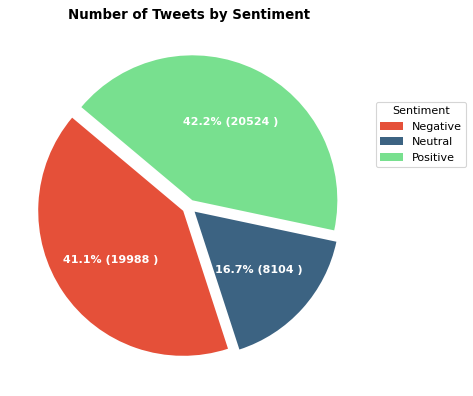

In [28]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
categories = ['Negative', 'Neutral', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Number of Tweets by Sentiment", fontsize=12, fontweight="bold")
plt.show()

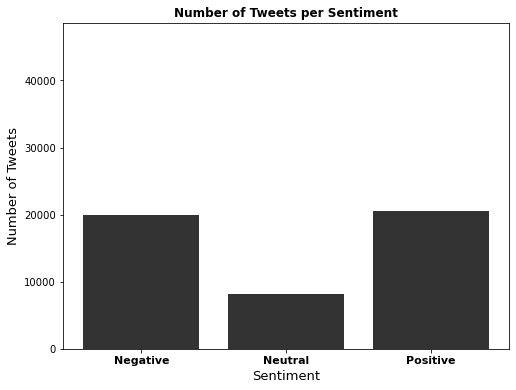

In [29]:
labels = ['Negative', 'Neutral', 'Positive']
freq = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
index = np.arange(len(freq))

plt.figure(figsize=(8,6))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Sentiment', fontsize=13)
plt.ylabel('Number of Tweets', fontsize=13)
plt.xticks(index, labels, fontsize=11, fontweight="bold") 
plt.title('Number of Tweets per Sentiment', fontsize=12, fontweight="bold")
plt.ylim(0, len(df['tweet_text']))
plt.show()

In [30]:
# We remove the neutral compound scores to compare the negative and positive tweets
data = df[(df["sentiment"]!=0)]

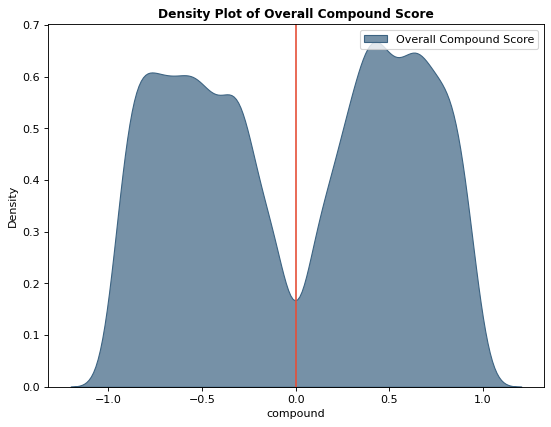

In [31]:
# Draw Plot
plt.figure(figsize=(8,6), dpi= 80)
sns.kdeplot(data["compound"], shade=True, color="#3c6382", label="Overall Compound Score", alpha=.7)

# Decoration
plt.title('Density Plot of Overall Compound Score', fontsize=11, fontweight='bold')
plt.axvline(x=0, color='#e55039')
plt.legend()
plt.show()

In [32]:
def lemmatization(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    tweets_out = []
    for sent in tweets:
        doc = nlp(" ".join(sent)) 
        tweets_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return tweets_out

In [33]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [34]:
# Do lemmatization keeping only noun, adj, vb, adv
df['lemmatized'] = lemmatization(df['tokens_no_stop'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [35]:
df.drop(['tokens_no_stop'], axis=1, inplace=True)

In [36]:
df_pos = df[df['sentiment']==1]
df_neg = df[df['sentiment']==(-1)]

In [37]:
df_pos.head()

,tweet_text,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,Islam is a religion full of blessings and good...,"Islam is a full of blessings and good deeds, ...",0.000,0.564,0.436,0.8910,1,"[full, blessing, good, deed, also, respect, li..."
4,plus my religion has never been 'holier' than ...,plus my has never been 'holier' than regular ...,0.000,0.811,0.189,0.4939,1,"[never, holier, regular, life, regular, life, ..."
8,"This whole ""religion of peace"" thing is starti...","This whole "" of peace"" thing is starting to ma...",0.141,0.665,0.194,0.2373,1,"[whole, peace, thing, start, make, trend, trust]"
9,Jorge Luis Borges~ To fall in love is to creat...,Jorge Luis Borges~ To fall in love is to creat...,0.000,0.567,0.433,0.8126,1,"[fall, love, create, fallible]"
12,I always think how cool it is that we managed ...,I always think how cool it is that we managed ...,0.000,0.741,0.259,0.7184,1,"[always, think, cool, manage, caveman, create,..."


In [38]:
# Join the tweet back together
def rejoin_words(row):
    words = row['lemmatized']
    joined_words = (" ".join(words))
    return joined_words

In [39]:
all_words_pos = ' '.join([text for text in df_pos.apply(rejoin_words, axis=1)])
all_words_neg = ' '.join([text for text in df_neg.apply(rejoin_words, axis=1)])

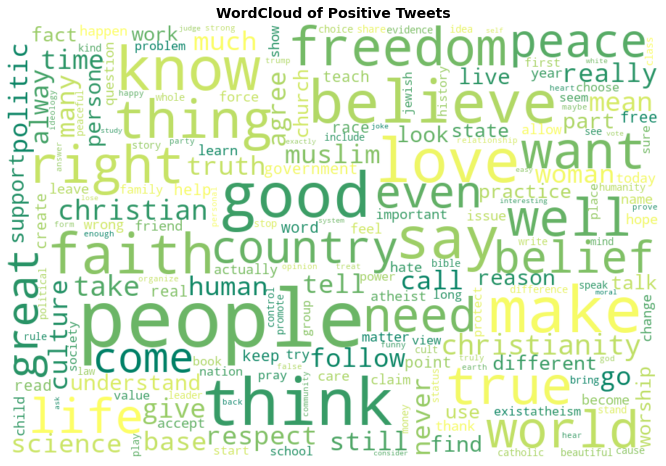

In [40]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=200,colormap='summer').generate(all_words_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

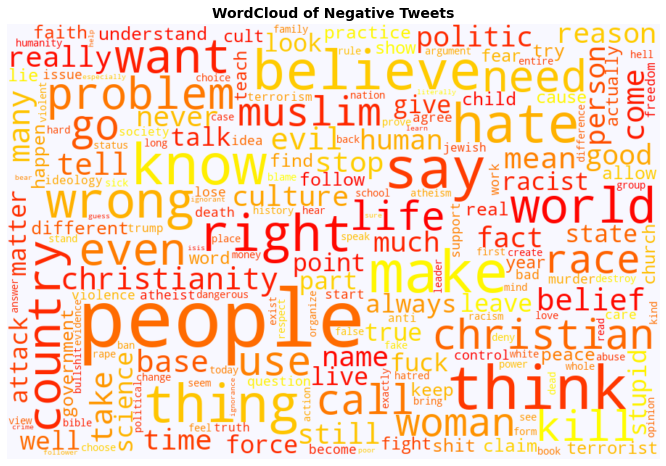

In [41]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=200,colormap='autumn').generate(all_words_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


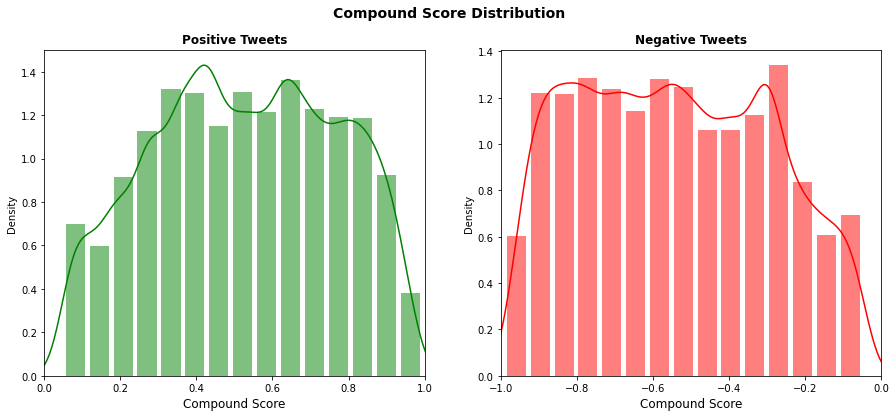

In [42]:
x1 = df_pos['compound']
x2 = df_neg['compound']
plt.figure(figsize=(15,6))
plt.suptitle('Compound Score Distribution', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)

sns.distplot(x1, color="g", bins=15, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title('Positive Tweets',fontsize=12, fontweight="bold")
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([0,1])

# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x2, color="r", bins=15, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Negative Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([-1,0])

plt.show()

In [43]:
x1.describe()

count    20524.000000
mean         0.526342
std          0.240198
min          0.050300
25%          0.340000
50%          0.526700
75%          0.725600
max          0.993200
Name: compound, dtype: float64

In [44]:
x2.describe()

count    19988.000000
mean        -0.542529
std          0.248756
min         -0.990200
25%         -0.757900
50%         -0.552300
75%         -0.340000
max         -0.050500
Name: compound, dtype: float64

In [45]:
# 10 Most positive Tweets
df_pos.sort_values('compound', inplace=True, ascending=False)
df_pos.reset_index(drop=True, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [46]:
df_pos.head(10)

,tweet_text,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,"Religion tells you to clean yourself up, then ...","tells you to clean yourself up, then God will...",0.083,0.385,0.532,0.9932,1,"[tell, clean, real, love, conditional, love, r..."
1,"Well, here in # Scotland, I cannot say I am ve...","Well, here in Scotland, I cannot say I am ver...",0.000,0.515,0.485,0.9898,1,"[spiritual, well, word, believe, kindness, kin..."
2,"Religion tells you to clean yourself up, then ...","tells you to clean yourself up, then God will...",0.000,0.458,0.542,0.9893,1,"[tell, clean, real, love, conditional, love, r..."
3,@ ComimDark6 # ApocisComing Absolutely right! ...,ApocisComing Absolutely right! The ability t...,0.000,0.459,0.541,0.9874,1,"[absolutely, right, ability, love, other, exis..."
4,Religion shouldn’t break your heart and make y...,shouldn’t break your heart and make you miser...,0.044,0.472,0.483,0.9868,1,"[break, heart, make, miserable, deserve, happi..."
5,prayer is the most genuine and sincere thing p...,prayer is the most genuine and sincere thing p...,0.000,0.554,0.446,0.9865,1,"[prayer, genuine, sincere, thing, people, know..."
6,"BE KIND, POLITE, HUMBLE, RESPECTFUL, CARING AN...","BE KIND, POLITE, HUMBLE, RESPECTFUL, CARING AN...",0.030,0.499,0.471,0.9857,1,"[kind, polite, humble, respectful, care, grate..."
7,@ BrandonStraka WELCOME! Republican Party is C...,WELCOME! Republican Party is Constitution 1st...,0.000,0.487,0.513,0.9857,1,"[welcome, constitution, freedom, speech, liber..."
8,All right f****** love it how nice is that ver...,All right f****** love it how nice is that ver...,0.000,0.465,0.535,0.9850,1,"[right, love, nice, peaceful, calm, respectful..."
9,@ KaeRobey has such natural beauty. She loves ...,has such natural beauty. She loves everyone. ...,0.000,0.502,0.498,0.9846,1,"[natural, beauty, love, period, care, social, ..."


In [47]:
# 10 Most Negative Tweets
df_neg.sort_values('compound', inplace=True)
df_neg.reset_index(drop=True).head(15)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,tweet_text,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,Faking a hate crime should be considered a hat...,Faking a hate crime should be considered a hat...,0.587,0.413,0.000,-0.9902,-1,"[fake, hate, crime, consider, hate, crime, rea..."
1,Religion caused the division of India and the ...,caused the division of India and the formatio...,0.522,0.478,0.000,-0.9881,-1,"[cause, division, formation, buddhism, cause, ..."
2,That's what they live for. The desalination of...,That's what they live for. The desalination of...,0.649,0.351,0.000,-0.9878,-1,"[live, desalination, other, hate, murder, rape..."
3,You use that the way you use fear and religion...,You use that the way you use fear and & those...,0.483,0.483,0.034,-0.9876,-1,"[fear, kill, immagrant, trouble, really, care,..."
4,Threatening murder against a poor woman is not...,Threatening murder against a poor woman is not...,0.500,0.466,0.034,-0.9873,-1,"[threaten, murder, poor, woman, protect, harm,..."
5,"Agreed, for all but Islam. It's a cult of war ...","Agreed, for all but Islam. It's a cult of war ...",0.525,0.448,0.027,-0.9871,-1,"[agree, death, call, confuse, public, beheadin..."
6,"Christ is dead too you know, but I hear y'all,...","Christ is dead too you know, but I hear y'all,...",0.452,0.478,0.070,-0.9867,-1,"[dead, know, hear, last, thing, need, bullshit..."
7,Difference of approach... Aftr a terror attack...,Difference of approach... Aftr a terror attack...,0.544,0.456,0.000,-0.9863,-1,"[difference, approach, always, cast, color, af..."
8,Murder is murder no matter the perpetrators or...,Murder is murder no matter the perpetrators or...,0.554,0.411,0.035,-0.9859,-1,"[murder, murder, matter, perpetrator, victim, ..."
9,"1828 Webster Hell HELL, noun 1. The place or s...","1828 Webster Hell HELL, noun 1. The place or s...",0.505,0.445,0.051,-0.9857,-1,"[place, state, punishment, wicked, death, matt..."


In [48]:
df.to_pickle('hate_speech_input.pkl')

In [49]:
df.head(10)

,tweet_text,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,Islam is a religion full of blessings and good...,"Islam is a full of blessings and good deeds, ...",0.000,0.564,0.436,0.8910,1,"[full, blessing, good, deed, also, respect, li..."
1,@ wagner_claire Religion and pity are antonyms...,"and pity are antonyms. One is disaster, othe...",0.247,0.605,0.148,-0.2023,-1,"[disaster, humanity, live, pity]"
2,if the only reason people are on twitter is to...,if the only reason people are on twitter is to...,0.130,0.870,0.000,-0.3400,-1,"[reason, people, argue, count]"
3,Religion is needed to provide a moral compass ...,is needed to provide a moral compass to those...,0.173,0.827,0.000,-0.3182,-1,"[need, provide, moral, compass, lack, empathy]"
4,plus my religion has never been 'holier' than ...,plus my has never been 'holier' than regular ...,0.000,0.811,0.189,0.4939,1,"[never, holier, regular, life, regular, life, ..."
5,Religion is the impotence of the human mind to...,is the impotence of the human mind to deal wi...,0.000,1.000,0.000,0.0000,0,"[impotence, human, mind, deal, occurrence, und..."
6,@ NoMoreDon8 # GoodIdea 'Do unto others as you...,GoodIdea 'Do unto others as you would have d...,0.103,0.845,0.052,-0.2732,-1,"[other, do, universal, matter, culture, belief..."
7,The principles he followed – Ahimsa and Satyag...,The principles he followed – Ahimsa and Satyag...,0.146,0.854,0.000,-0.4404,-1,"[principle, follow, ahimsa, satyagraha, expel,..."
8,"This whole ""religion of peace"" thing is starti...","This whole "" of peace"" thing is starting to ma...",0.141,0.665,0.194,0.2373,1,"[whole, peace, thing, start, make, trend, trust]"
9,Jorge Luis Borges~ To fall in love is to creat...,Jorge Luis Borges~ To fall in love is to creat...,0.000,0.567,0.433,0.8126,1,"[fall, love, create, fallible]"


In [50]:
df.tweet_text[46]

'Religion is the enemy of truth and truth is the enemy of religion.'

In [51]:
tweet = df.tweet_text[46]

In [52]:
sentiment_dict = vader_analyzer.polarity_scores(tweet) 
      
print("Overall sentiment is : ", sentiment_dict) 
print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
print("Sentence Overall Rated As", end = " ")
# decide sentiment as positive, negative and neutral 
if sentiment_dict['compound'] >= 0.05 : 
    print("Positive") 
elif sentiment_dict['compound'] <= - 0.05 : 
    print("Negative")  
else : 
    print("Neutral") 

Overall sentiment is :  {'neg': 0.34, 'neu': 0.437, 'pos': 0.223, 'compound': -0.5267}
sentence was rated as  34.0 % Negative
sentence was rated as  43.7 % Neutral
sentence was rated as  22.3 % Positive
Sentence Overall Rated As Negative


In [53]:
df.drop(['tweet_text_p', 'lemmatized'], axis=1, inplace=True)

In [54]:
df.to_pickle('sentiment_analysis_vader_results.pkl')